# Trajectory planning for multi-agent systems

This notebook contains a scalable version of the multi-agent navigation case study with a simplified layout.

This case study uses _merging_ of _PolyhedralContractCompounds_ and model checking by calling _contains_behavior_ for each possible next position.

Some info on the number of operations:

This happens once at the start:

1. Swapping contract and collision contract -> merged

This happens for each timestep:

2. Each robot has a dynamics contract, they are merged by adding one at a time
3. The resuting dynamics contract is merged again with the contract from 1.
4. Then each possible next position (combination of all robots' positions) is checked using the contains_behavior function (I expect this to be the cause for the long run time as the number of possible next positions explodes when adding another robot - I would suggest sticking with 1 or 2 robots and increasing the length of the corridor $l_{corridor}$).

In [1]:
%matplotlib inline
import numpy as np
from utils.multiagent_utils import (
    Coord,
    Robot,
    distance,
    get_collision_contract,
    get_swapping_contract,
    strategy_multiple_simple,
    find_move_candidates_general,
    find_move_candidates_general_par
)
from utils.plotting_utils import plot_grid_world

from pacti.iocontract import Var
from pacti.terms.polyhedra import PolyhedralContractCompound

### Create gridworld and robots

We will set up the grid world such that all robots start in the same lane as their respective goal such that the grid world is set up as a corridor, with the scaling parameters the number of robots $n_{robots}$ and the corridor length $l_{corridor}$.

To visualize the setup:

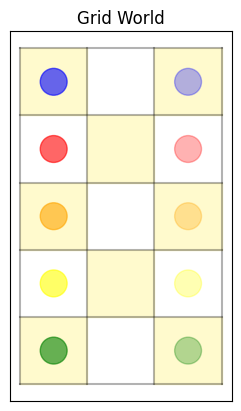

In [2]:
# Define the grid world dimensions
n_robots = 5
l_corridor = 3

# Initialize the robots
robots = []
for i in range(n_robots):
    robots.append(Robot("r"+str(i), (0, i), (l_corridor-1, i)))

plot_grid_world(l_corridor, n_robots, robots)

### Define dynamics contracts for each robot per timestep
The contracts are explained in detail in the multiagent.ipynb notebook.

In [3]:
def get_dynamics_contract_robot(name: str, init_pos: Coord, timestep: int, grid_n: int, grid_m: int
) -> PolyhedralContractCompound:  # noqa: WPS210
    """
    Function to set up the contract encoding the dynamics for a single robot for the next timestep.

    Args:
        name: name of the robot
        init_pos: current coordinates of the robot
        timestep: current timestep

    Returns:
        Resulting contract compound that encodes the dynamics for the robot.
    """
    x_str_0 = 'x_{0}_0'.format(name)
    y_str_0 = 'y_{0}_0'.format(name)
    x_str_1 = 'x_{0}_1'.format(name)
    y_str_1 = 'y_{0}_1'.format(name)
    t_0 = 't_0'
    t_1 = 't_1'

    contract = PolyhedralContractCompound.from_string(
        input_vars=[x_str_0, y_str_0, t_0],
        output_vars=[x_str_1, y_str_1, t_1],
        assumptions=[
            [
                "{0} = {1}".format(x_str_0, init_pos.x),
                "{0} = {1}".format(y_str_0, init_pos.y),
                "{0} = {1}".format(t_0, timestep),
            ]
        ],
        guarantees=[
            [
                "{0} - {1} = 1".format(t_1, t_0),
                "{0} - {1} + {2} - {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "{0} - {1} - {2} + {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "-{0} + {1} + {2} - {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "-{0} + {1} - {2} + {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "{0} <= {1}".format(x_str_1, grid_n - 1),
                "{0} <= {1}".format(y_str_1, grid_m - 1),
                "-{0} <= 0".format(x_str_1),
                "-{0} <= 0".format(y_str_1),
            ]
        ],
    )
    return contract

### Extension to N robots and a grid length of L

In [4]:
# Show info about the hardware we're using.
from cpuinfo import get_cpu_info
cpu_info = get_cpu_info()
cpu_info_message = f"{cpu_info['brand_raw']} @ {cpu_info['hz_advertised_friendly']} with up to {cpu_info['count']} threads."
print(f"Running on {cpu_info_message}")

Running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.



Choose the number of robots in $n_{robots}$ and the grid length in $l_{corridor}$. The maximum number of timesteps is set to be 3 times the grid length (as upper bound). The robots will be placed as shown in the visualization above. The function below does not produce any animation or save the trace of the simulation.

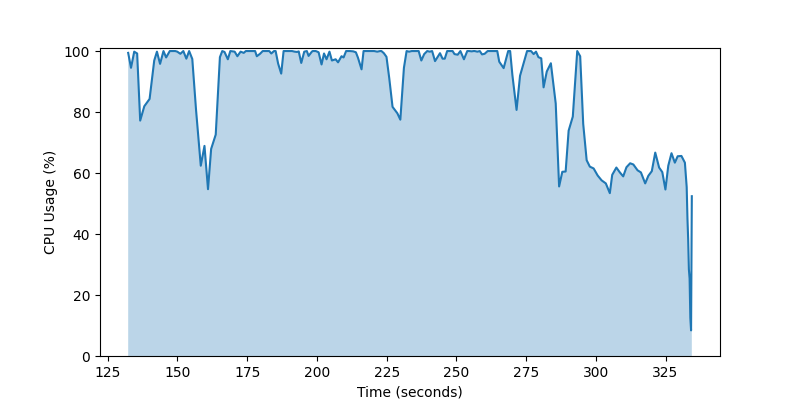

Output()

Found 262 possible_sol out of 1944 next_possible_positions in 334.37 seconds.
[(3, 0), (3, 1), (3, 2), (3, 3)]
Taking move: [(2, 0), (2, 1), (1, 2), (1, 3)]
Evaluating 4374 next_possible_positions...


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01\x90\x08\x06\x00\x00\x00V%\x044\x00\…

Output()

In [5]:
def run_sim(n_robots,l_corridor):
    grid_n = l_corridor
    grid_m = n_robots

    # Initialize the robots
    robots = []
    for i in range(n_robots):
        robots.append(Robot("r"+str(i), (0, i), (l_corridor-1, i)))

    plot_grid_world(l_corridor, n_robots, robots)

    num_iter = l_corridor * 3 # estimated maximum time steps that it might take

    # Get the contracts ensuring no conflicts
    if n_robots > 1:
        c_collision = get_collision_contract(robots)
        c_swapping = get_swapping_contract(robots)
        c_no_conflicts = c_collision.merge(c_swapping)

    t_0 = 0

    for _j in range(0, num_iter):  # noqa: WPS122
        # merge the dynamics contracts

        dynamics_contract = get_dynamics_contract_robot(robots[0].name, robots[0].pos, t_0, grid_n, grid_m)
        for robot in robots[1:]:
            contract = get_dynamics_contract_robot(robot.name, robot.pos, t_0, grid_n, grid_m)
            dynamics_contract.merge(contract)

        # merge dynamics with the no conflict contracts
        if n_robots > 1:
            multiagent_contract = dynamics_contract.merge(c_no_conflicts)
        else:
            multiagent_contract = dynamics_contract

        moves_list, t_1 = find_move_candidates_general_par(grid_n, grid_m, robots, t_0, multiagent_contract)
        goals = [robot.goal for robot in robots]
        print([(goal.x, goal.y) for goal in goals])

        move = strategy_multiple_simple(moves_list, goals)
        print('Taking move: {}'.format(move))

        for i,robot in enumerate(robots):
            robot.move(move[i])

        if distance([[robot.pos.x, robot.pos.y] for robot in robots], [robot.goal for robot in robots]) == 0:
            print('All robots reached their goal.')
            break

# Define the number of robots and grid size
n_robots = 4
l_corridor = 4
run_sim(n_robots,l_corridor)